# Clase 3. Preparación de datos. 

## Sección 4. Desbalance de datos.

Este cuaderno contiene los ejemplos de la sección de desbalance de datos en python/SKLearn que acompañan a la [presentación de la clase](../add_clase3.pdf).

**Ejemplos**

- Undersampling
- Oversampling
- Generación de datos sintéticos

In [1]:
!pip install imbalanced-learn

In [2]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_moons

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

# métodos necesarios para desbalance
from imblearn.datasets import make_imbalance
from collections import Counter

#print(__doc__)
#sns.set_context("poster")

np.random.seed(42)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

Pandas:1.3.5
Numpy:1.23.2
Matplotlib:3.5.3
SKlearn:1.1.2
Seaborn:0.12.0



# Generación del dataset

Para esta primera parte vamos a generar un dataset a partir de por ejemplo _make_moons_ y luego vamos a generar el desbalance de manera sintética

In [3]:
X, y = make_moons(n_samples=200, shuffle=True, noise=0.5, random_state=10)
X = pd.DataFrame(X, columns=["feature 1", "feature 2"])

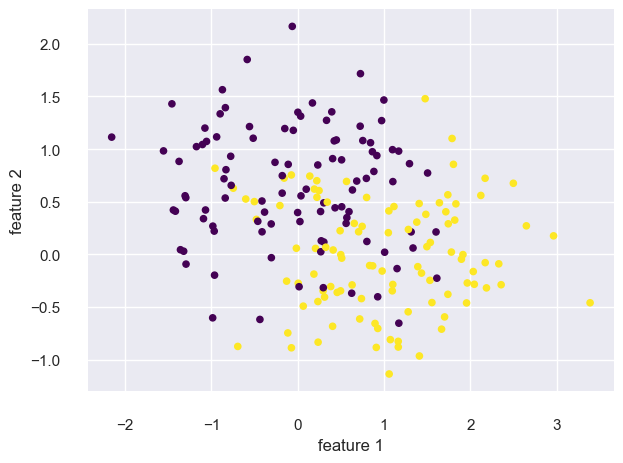

In [4]:
ax = X.plot.scatter(
    x="feature 1",
    y="feature 2",
    c=y,
    colormap="viridis",
    colorbar=False,
)
sns.despine(ax=ax, offset=10)
plt.tight_layout()

## A desbalancear!!

Para esto vamos a utilizar una función de la libreria que importamos `imbalanced-learn`

In [5]:
def ratio_func(y, multiplier, minority_class):
    target_stats = Counter(y)
    return {minority_class: int(multiplier * target_stats[minority_class])}

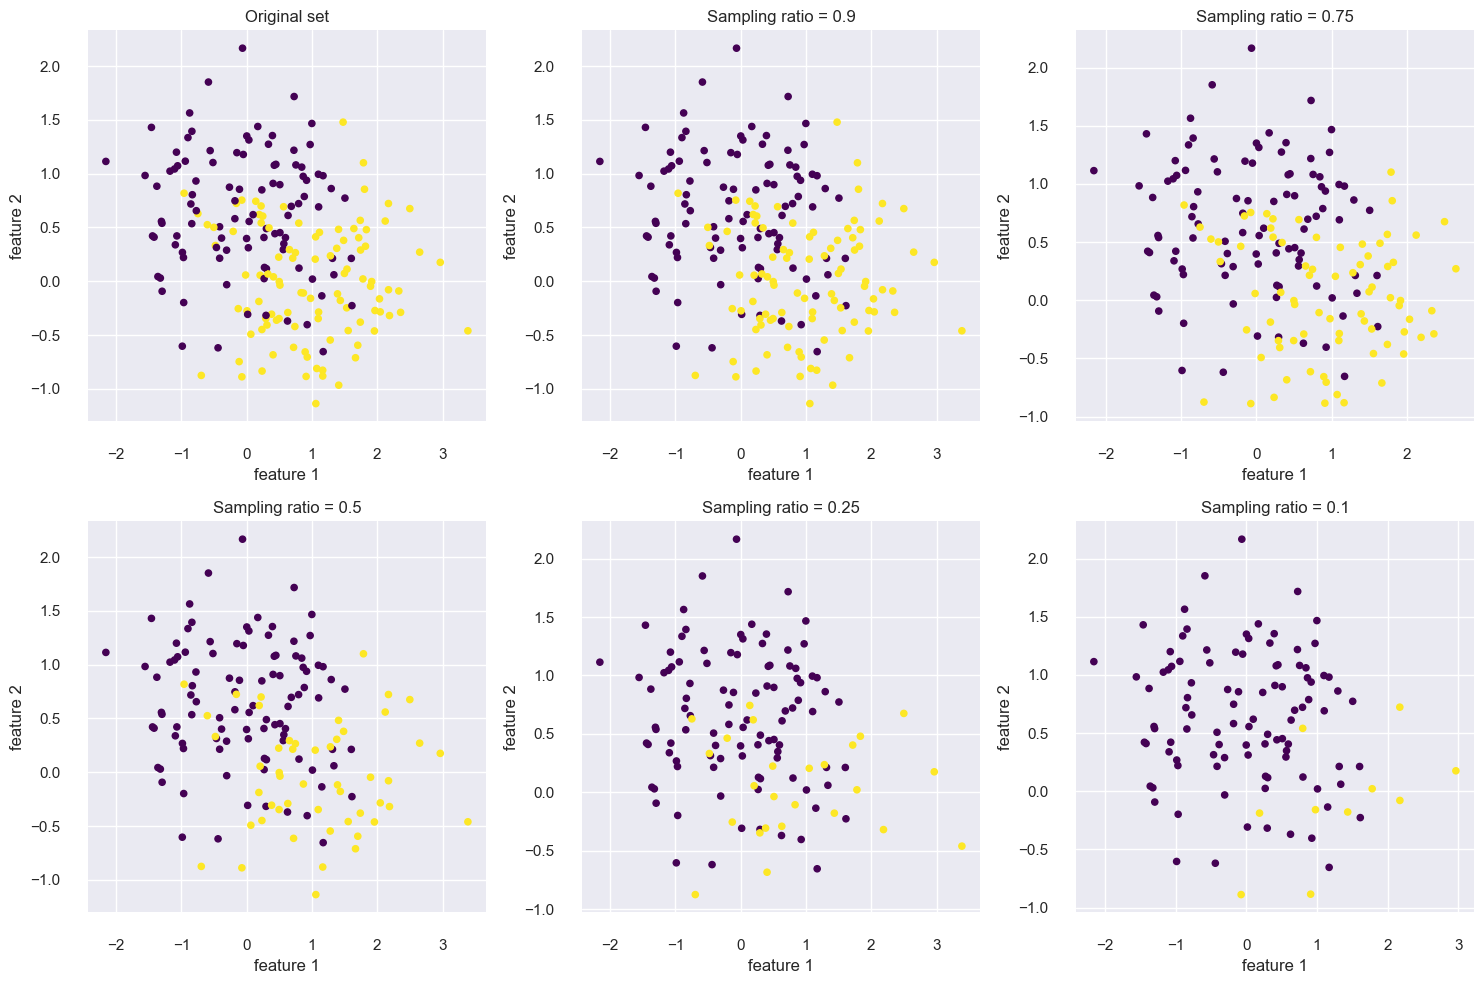

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

X.plot.scatter(
    x="feature 1",
    y="feature 2",
    c=y,
    ax=axs[0, 0],
    colormap="viridis",
    colorbar=False,
)
axs[0, 0].set_title("Original set")
sns.despine(ax=axs[0, 0], offset=10)

multipliers = [0.9, 0.75, 0.5, 0.25, 0.1]
for ax, multiplier in zip(axs.ravel()[1:], multipliers):
    X_resampled, y_resampled = make_imbalance(
        X,
        y,
        sampling_strategy=ratio_func,
        **{"multiplier": multiplier, "minority_class": 1},
    )
    X_resampled.plot.scatter(
        x="feature 1",
        y="feature 2",
        c=y_resampled,
        ax=ax,
        colormap="viridis",
        colorbar=False,
    )
    ax.set_title(f"Sampling ratio = {multiplier}")
    sns.despine(ax=ax, offset=10)

plt.tight_layout()
plt.show()

## Efecto sobre el modelo

Vamos a ver como se afecta el modelo a medida que comenzamos a desbalancear la muestra

In [7]:
from sklearn.base import clone

models = [
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("RandomForest", RandomForestClassifier(n_estimators=200, random_state=42)),
    ("SVM", SVC(random_state=44, probability=True, gamma='auto')),    
    ("LogisticRegression", LogisticRegression(random_state=42, C=1000, solver='lbfgs'))
]

imb_ratios = [0.9, 0.75, 0.5, 0.25, 0.1]

In [11]:
results = {}

for m in models:
    for ratio in imb_ratios:
        # De la doc de SKlearn:
        # Clone does a deep copy of the model in an estimator without actually copying attached data. 
        # It yields a new estimator with the same parameters that has not been fitted on any data.
        model_name = m[0]
        if model_name not in results.keys():
            results[model_name] = {}
        results[model_name][f"imb_ratio_{ratio}"] = {}
        model = clone(m[1])

        X_resampled, y_resampled = make_imbalance(
            X,
            y,
            sampling_strategy = ratio_func,
            **{"multiplier": ratio, "minority_class": 1},
        )

        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled,
            y_resampled,
            test_size = 0.3,
            random_state = 0)

        # Versión sin escalar features    
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        results[model_name][f"imb_ratio_{ratio}"]["train"] = fbeta_score(y_train, pred_train, beta=0.25)
        results[model_name][f"imb_ratio_{ratio}"]["test"] = non_red_score_test = fbeta_score(y_test, pred_test, beta=0.25)


results = pd.DataFrame([[model,split,score['train'],score['test']] for model, imb in results.items() for split, score in imb.items()],
 columns = ['model', 'ratio', 'train', 'test'])
results

,model,ratio,train,test
0,KNN,imb_ratio_0.9,0.817992,0.800448
1,KNN,imb_ratio_0.75,0.784335,0.697039
2,KNN,imb_ratio_0.5,0.751105,0.506383
3,KNN,imb_ratio_0.25,0.846743,0.257576
4,KNN,imb_ratio_0.1,0.957746,0.000000
5,RandomForest,imb_ratio_0.9,1.000000,0.846863
6,RandomForest,imb_ratio_0.75,1.000000,0.710306
7,RandomForest,imb_ratio_0.5,1.000000,0.454849
8,RandomForest,imb_ratio_0.25,1.000000,0.000000
9,RandomForest,imb_ratio_0.1,1.000000,0.485714


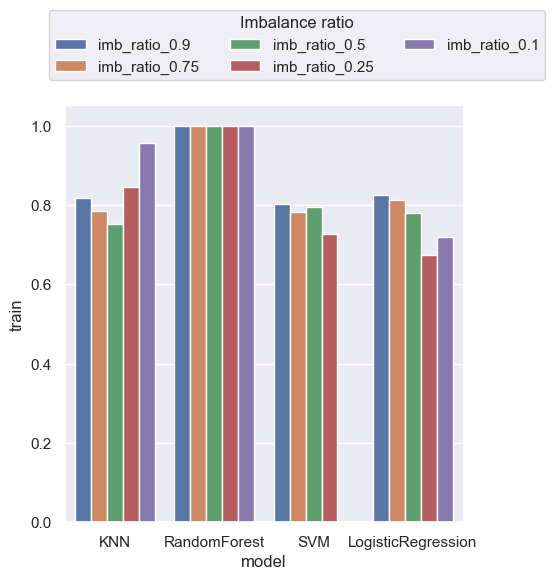

In [12]:
g = sns.catplot(data = results,
    x = 'model',
    y = 'train',
    hue = 'ratio',
    kind = "bar")
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title = "Imbalance ratio", frameon = True,
)
plt.show(g)